# Лабораторная работа 3. 
# Сетевые алгоритмы. Динамические алгоритмы поиска путей.


## Выполнил студент группы Григоренко Дарья БФИ2302
***

### Задание

1.  Реализовать алгоритм поиска кратчайшего расстояния между двумя вершинами ориентированного взвешенного графа в соответствии с вариантом. 

2.  Предусмотреть задание графа в виде матрицы смежности/инцидентности, читаемой из файла, либо графически с помощью пользовательского интерфейса. 

3.  Разработать графический интерфейс пользователя с визуализацией графа и отображением кратчайшего расстояния между задаваемыми пользователем вершинами.

4. По результатам работы проанализировать временную сложность работы заданного алгоритма в зависимости от числа узлов и ребер графа.
Данные представить в виде таблицы.



### Алгоритмы:

Алгоритм Флойда-Уоршелла| Алгоритм Дейкстры | Алгоритм Беллмана-Форда | Алгоритм Джонсона| Алгоритм Левита | Алгоритм Йена



### Выполнение:

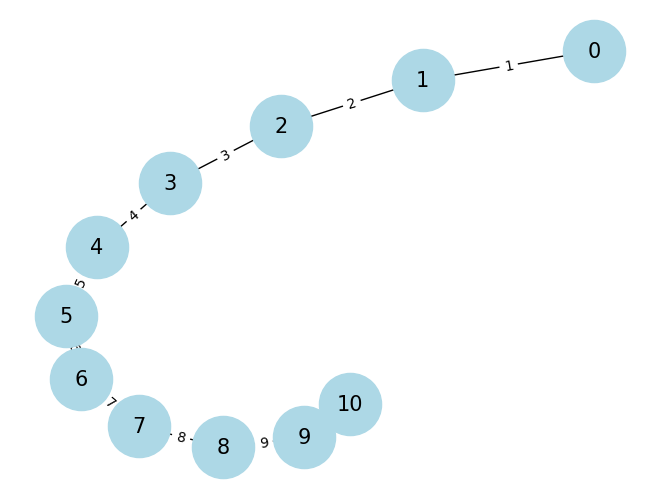

In [2]:
### Алгоритм Беллмана-Форда

import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
import networkx as nx
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

def read_matrix(filename):
    with open(filename, 'r') as f:
        return [list(map(int, line.split())) for line in f]

def bellman_ford(graph, start):
    V = len(graph)
    distances = [float('inf')] * V  #расстояния
    distances[start] = 0  

    for _ in range(V - 1):   # длина пути
        for i in range(V):
            for j in range(V):
                if graph[i][j] != 0 and distances[i] + graph[i][j] < distances[j]:
                    distances[j] = distances[i] + graph[i][j]

    # отриц
    for i in range(V):
        for j in range(V):
            if graph[i][j] != 0 and distances[i] + graph[i][j] < distances[j]:
                return None  

    return distances

class GraphGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Алгоритм Беллмана-Форда")

        self.load_button = tk.Button(root, text="Загрузить граф", command=self.load_graph)
        self.load_button.pack()

        self.start_label = tk.Label(root, text="Выберите стартовую вершину:")
        self.start_label.pack()

        self.start_entry = tk.Entry(root)
        self.start_entry.pack()

        self.run_button = tk.Button(root, text="Запустить алгоритм", command=self.run_algorithm)
        self.run_button.pack()

        self.result_label = tk.Label(root, text="")
        self.result_label.pack()

        self.analyze_button = tk.Button(root, text="Анализ временной сложности", command=self.analyze_time_complexity)
        self.analyze_button.pack()

    def load_graph(self):
        filename = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
        if filename:
            #matrix_type = input("Введите тип матрицы (adjacency/incidence): ").strip()
            self.graph = read_matrix(filename)

    def run_algorithm(self):
        if not hasattr(self, 'graph'):
            self.result_label.config(text="Граф не загружен!")
            return

        try:
            start_vertex = int(self.start_entry.get())
        except ValueError:
            self.result_label.config(text="Неверный номер вершины!")
            return

        distances = bellman_ford(self.graph, start_vertex)
        if distances is None:
            self.result_label.config(text="Граф содержит отрицательный цикл")
        else:
            self.result_label.config(text=f"Расстояния от вершины {start_vertex}: {distances}")
            self.visualize_graph()

    def visualize_graph(self):
        G = nx.Graph()
        edges = [(i, j, self.graph[i][j]) for i in range(len(self.graph)) for j in range(len(self.graph)) if self.graph[i][j] != 0]
        G.add_weighted_edges_from(edges)

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=15)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

    def analyze_time_complexity(self): #4
        folder_path = filedialog.askdirectory(title="Выберите папку с файлами графов")
        if not folder_path:
            return

        files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

        if not files:
            messagebox.showerror("Ошибка", "В выбранной папке нет файлов .txt")
            return

        results = []

        for filename in files:
            graph = read_matrix(os.path.join(folder_path, filename))
            V = len(graph)
            E = sum(1 for i in range(V) for j in range(V) if graph[i][j] != 0)

            start_time = time.time()
            bellman_ford(graph, 0) 
            elapsed_time = (time.perf_counter() - start_time) % 1000000

            results.append((V, E, elapsed_time))

        # таблица
        df = pd.DataFrame(results, columns=["Число узлов", "Число рёбер", "Время (сек.)"])

        self.show_time_analysis(df)

    def show_time_analysis(self, df):
        top = tk.Toplevel(self.root)
        top.title("Анализ временной сложности")

        text = tk.Text(top, width=60, height=20)
        text.pack()

        # вывод в окно
        text.insert(tk.END, df.to_string(index=False))
        text.config(state=tk.DISABLED)

root = tk.Tk()
app = GraphGUI(root)
root.mainloop()


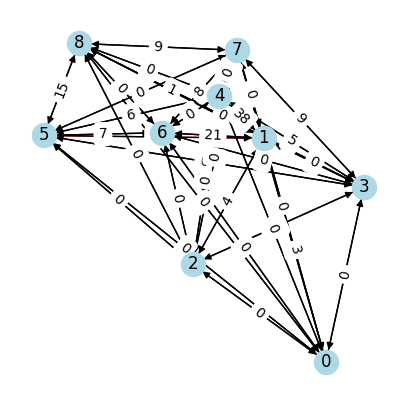

In [2]:
### Алгоритм Флойда-Уоршелла
import tkinter as tk
from tkinter import filedialog, messagebox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time

INF = float('inf')

def read_graph_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        graph = []
        for line in lines:
            row = []
            for val in line.strip().split():
                if val.lower() == 'inf':
                    row.append(INF)
                else:
                    row.append(int(val))
            graph.append(row)
        return graph

def floyd_warshall(graph):
    V = len(graph)
    dist = [row[:] for row in graph]
    next_node = [[None if graph[i][j] == INF else j for j in range(V)] for i in range(V)]

    for k in range(V):
        for i in range(V):
            for j in range(V):
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    next_node[i][j] = next_node[i][k]

    return dist, next_node

def reconstruct_path(u, v, next_node):
    if next_node[u][v] is None:
        return []
    path = [u]
    while u != v:
        u = next_node[u][v]
        path.append(u)
    return path

class GraphApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Floyd-Warshall Visualization")

        self.graph = []
        self.dist = []
        self.next_node = []

        self.left_frame = tk.Frame(root)
        self.left_frame.pack(side=tk.LEFT, padx=10, pady=10)

        self.load_button = tk.Button(self.left_frame, text="Загрузить граф из файла", command=self.load_graph)
        self.load_button.pack(pady=5)

        self.label_from = tk.Label(self.left_frame, text="От вершины:")
        self.label_from.pack()
        self.entry_from = tk.Entry(self.left_frame)
        self.entry_from.pack()

        self.label_to = tk.Label(self.left_frame, text="До вершины:")
        self.label_to.pack()
        self.entry_to = tk.Entry(self.left_frame)
        self.entry_to.pack()

        self.show_button = tk.Button(self.left_frame, text="Показать кратчайший путь", command=self.show_shortest_path)
        self.show_button.pack(pady=5)

        self.output = tk.Text(self.left_frame, height=5, width=40)
        self.output.pack(pady=5)

        self.right_frame = tk.Frame(root)
        self.right_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.get_tk_widget().pack()

    def load_graph(self):
        file_path = filedialog.askopenfilename()
        if not file_path:
            return
        try:
            self.graph = read_graph_from_file(file_path)
            self.dist, self.next_node = floyd_warshall(self.graph)
            self.draw_graph()
            messagebox.showinfo("Успешно", "Граф успешно загружен и обработан!")
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def draw_graph(self, path=None):
        self.ax.clear()
        G = nx.DiGraph()

        for i in range(len(self.graph)):
            for j in range(len(self.graph[i])):
                if self.graph[i][j] != INF and i != j:
                    G.add_edge(i, j, weight=self.graph[i][j])

        pos = nx.spring_layout(G)
        edge_colors = ['red' if path and (u in path and v in path and path.index(v) == path.index(u)+1) else 'black' for u, v in G.edges()]

        nx.draw(G, pos, ax=self.ax, with_labels=True, edge_color=edge_colors, node_color='lightblue')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=self.ax)
        self.canvas.draw()

    def show_shortest_path(self):
        try:
            u = int(self.entry_from.get())
            v = int(self.entry_to.get())
            if not (0 <= u < len(self.graph)) or not (0 <= v < len(self.graph)):
                raise ValueError("Неверные номера вершин")

            path = reconstruct_path(u, v, self.next_node)
            distance = self.dist[u][v]

            self.output.delete("1.0", tk.END)
            if path:
                self.output.insert(tk.END, f"Кратчайший путь: {path}\n")
                self.output.insert(tk.END, f"Длина пути: {distance}")
                self.draw_graph(path)
            else:
                self.output.insert(tk.END, "Пути не существует.")
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))


# Запуск приложения
if __name__ == "__main__":
    root = tk.Tk()
    app = GraphApp(root)
    root.mainloop()


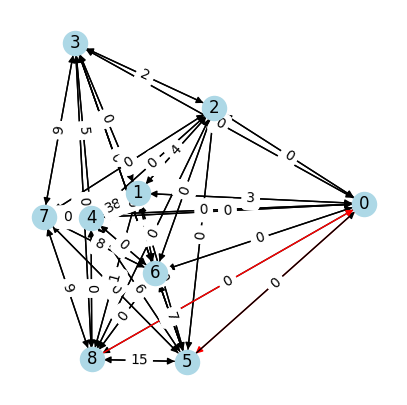

In [1]:
###  Алгоритм Дейкстры
import tkinter as tk
from tkinter import filedialog, messagebox
import heapq
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time

INF = float('inf')

def read_graph_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        graph = []
        for line in lines:
            row = []
            for val in line.strip().split():
                if val.lower() == 'inf':
                    row.append(INF)
                else:
                    row.append(int(val))
            graph.append(row)
        return graph

def dijkstra(graph, start):
    V = len(graph)
    dist = [INF] * V
    prev = [None] * V
    dist[start] = 0
    queue = [(0, start)]

    while queue:
        d, u = heapq.heappop(queue)
        if d > dist[u]:
            continue
        for v, weight in enumerate(graph[u]):
            if weight != INF:
                alt = dist[u] + weight
                if alt < dist[v]:
                    dist[v] = alt
                    prev[v] = u
                    heapq.heappush(queue, (alt, v))

    return dist, prev

def reconstruct_path(prev, target):
    path = []
    while target is not None:
        path.append(target)
        target = prev[target]
    return path[::-1]

class DijkstraApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Визуализация алгоритма Дейкстры")

        self.graph = []
        self.dist = []
        self.prev = []

        self.left_frame = tk.Frame(root)
        self.left_frame.pack(side=tk.LEFT, padx=10, pady=10)

        self.load_button = tk.Button(self.left_frame, text="Загрузить граф из файла", command=self.load_graph)
        self.load_button.pack(pady=5)

        self.label_from = tk.Label(self.left_frame, text="Начальная вершина:")
        self.label_from.pack()
        self.entry_from = tk.Entry(self.left_frame)
        self.entry_from.pack()

        self.label_to = tk.Label(self.left_frame, text="Конечная вершина:")
        self.label_to.pack()
        self.entry_to = tk.Entry(self.left_frame)
        self.entry_to.pack()

        self.show_button = tk.Button(self.left_frame, text="Показать кратчайший путь", command=self.show_shortest_path)
        self.show_button.pack(pady=5)

        self.output = tk.Text(self.left_frame, height=5, width=40)
        self.output.pack(pady=5)

        self.right_frame = tk.Frame(root)
        self.right_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.get_tk_widget().pack()

    def load_graph(self):
        file_path = filedialog.askopenfilename()
        if not file_path:
            return
        try:
            self.graph = read_graph_from_file(file_path)
            messagebox.showinfo("Успешно", "Граф успешно загружен!")
            self.draw_graph()
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def draw_graph(self, path=None):
        self.ax.clear()
        G = nx.DiGraph()

        for i in range(len(self.graph)):
            for j in range(len(self.graph[i])):
                if self.graph[i][j] != INF and i != j:
                    G.add_edge(i, j, weight=self.graph[i][j])

        pos = nx.spring_layout(G)
        edge_colors = ['red' if path and (u in path and v in path and path.index(v) == path.index(u)+1) else 'black' for u, v in G.edges()]

        nx.draw(G, pos, ax=self.ax, with_labels=True, edge_color=edge_colors, node_color='lightblue')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=self.ax)
        self.canvas.draw()

    def show_shortest_path(self):
        try:
            u = int(self.entry_from.get())
            v = int(self.entry_to.get())
            if not (0 <= u < len(self.graph)) or not (0 <= v < len(self.graph)):
                raise ValueError("Неверные номера вершин")

            self.dist, self.prev = dijkstra(self.graph, u)
            path = reconstruct_path(self.prev, v)
            distance = self.dist[v]

            self.output.delete("1.0", tk.END)
            if distance != INF:
                self.output.insert(tk.END, f"Кратчайший путь: {path}\n")
                self.output.insert(tk.END, f"Длина пути: {distance}")
                self.draw_graph(path)
            else:
                self.output.insert(tk.END, "Пути не существует.")
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

# Запуск приложения
if __name__ == "__main__":
    root = tk.Tk()
    app = DijkstraApp(root)
    root.mainloop()


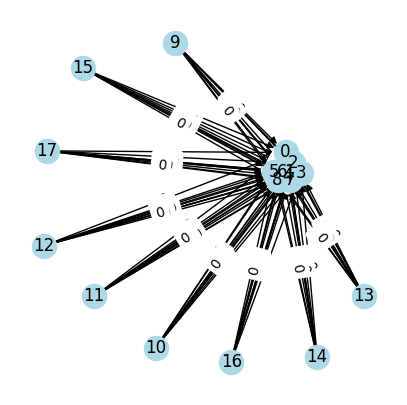

In [1]:
### Алгоритм Джонсона
import tkinter as tk
from tkinter import filedialog, messagebox
import heapq
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

INF = float('inf')

# Чтение графа из файла
def read_graph_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        graph = []
        for line in lines:
            row = []
            for val in line.strip().split():
                if val.lower() == 'inf':
                    row.append(INF)
                else:
                    row.append(int(val))
            graph.append(row)
        return graph

# Алгоритм Беллмана-Форда для вычисления потенциалов
def bellman_ford(graph, src):
    V = len(graph)
    dist = [INF] * V
    dist[src] = 0

    for _ in range(V):
        for u in range(V):
            for v, weight in enumerate(graph[u]):
                if weight != INF and dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight

    return dist

# Алгоритм Дейкстры
def dijkstra(graph, start, adj):
    V = len(graph)
    dist = [INF] * V
    dist[start] = 0
    pq = [(0, start)]

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        for v, weight in adj[u]:
            if dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                heapq.heappush(pq, (dist[v], v))

    return dist

# Алгоритм Джонсона
def johnson(graph):
    # Добавляем фиктивную вершину
    V = len(graph)
    for i in range(V):
        graph.append([0] * V)  # Добавляем рёбра с нулевыми весами от фиктивной вершины

    # Запускаем Беллмана-Форда
    h = bellman_ford(graph, V)

    # Пересчитываем веса рёбер
    new_adj = [[] for _ in range(V)]
    for u in range(V):
        for v in range(V):
            if graph[u][v] != INF:
                new_w = graph[u][v] + h[u] - h[v]
                new_adj[u].append((v, new_w))

    # Запускаем Дейкстру для каждой вершины
    dist_matrix = []
    for u in range(V):
        dist_u = dijkstra(graph, u, new_adj)
        dist_u = [d - h[u] + h[v] if d != INF else INF for v, d in enumerate(dist_u)]
        dist_matrix.append(dist_u)

    return dist_matrix

# Приложение для визуализации алгоритма Джонсона
class JohnsonApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Визуализация алгоритма Джонсона")

        self.graph = []
        self.dist_matrix = []

        self.left_frame = tk.Frame(root)
        self.left_frame.pack(side=tk.LEFT, padx=10, pady=10)

        self.load_button = tk.Button(self.left_frame, text="Загрузить граф из файла", command=self.load_graph)
        self.load_button.pack(pady=5)

        self.label_from = tk.Label(self.left_frame, text="Начальная вершина:")
        self.label_from.pack()
        self.entry_from = tk.Entry(self.left_frame)
        self.entry_from.pack()

        self.label_to = tk.Label(self.left_frame, text="Конечная вершина:")
        self.label_to.pack()
        self.entry_to = tk.Entry(self.left_frame)
        self.entry_to.pack()

        self.show_matrix_button = tk.Button(self.left_frame, text="Показать матрицу кратчайших путей", command=self.show_shortest_paths_matrix)
        self.show_matrix_button.pack(pady=5)

        self.show_path_button = tk.Button(self.left_frame, text="Показать кратчайший путь", command=self.show_selected_path)
        self.show_path_button.pack(pady=5)

        self.output = tk.Text(self.left_frame, height=10, width=40)
        self.output.pack(pady=5)

        self.right_frame = tk.Frame(root)
        self.right_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.get_tk_widget().pack()

    def load_graph(self):
        file_path = filedialog.askopenfilename()
        if not file_path:
            return
        try:
            self.graph = read_graph_from_file(file_path)
            messagebox.showinfo("Успешно", "Граф успешно загружен!")
            self.draw_graph()
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def draw_graph(self, path=None):
        self.ax.clear()
        G = nx.DiGraph()

        for i in range(len(self.graph)):
            for j in range(len(self.graph[i])):
                if self.graph[i][j] != INF and i != j:
                    G.add_edge(i, j, weight=self.graph[i][j])

        pos = nx.spring_layout(G)
        edge_colors = []
        for u, v in G.edges():
            if path and u in path and v in path:
                if path.index(v) == path.index(u) + 1:
                    edge_colors.append("red")
                else:
                    edge_colors.append("black")
            else:
                edge_colors.append("black")

        nx.draw(G, pos, ax=self.ax, with_labels=True, node_color='lightblue', edge_color=edge_colors)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=self.ax)
        self.canvas.draw()

    def show_shortest_paths_matrix(self):
        try:
            self.dist_matrix = johnson(self.graph)

            self.output.delete("1.0", tk.END)
            self.output.insert(tk.END, "Матрица кратчайших путей:\n")
            for row in self.dist_matrix:
                self.output.insert(tk.END, ' '.join([f"{d if d != INF else 'inf':>5}" for d in row]) + '\n')

            self.draw_graph()
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def show_selected_path(self):
        try:
            if not self.dist_matrix:
                self.dist_matrix = johnson(self.graph)

            u = int(self.entry_from.get())
            v = int(self.entry_to.get())
            if not (0 <= u < len(self.graph)) or not (0 <= v < len(self.graph)):
                raise ValueError("Неверные номера вершин")

            path = self.reconstruct_path(u, v)
            distance = self.dist_matrix[u][v]

            self.output.delete("1.0", tk.END)
            if distance != INF:
                self.output.insert(tk.END, f"Кратчайший путь: {path}\n")
                self.output.insert(tk.END, f"Длина пути: {distance}")
                self.draw_graph(path)
            else:
                self.output.insert(tk.END, "Пути не существует.")
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def reconstruct_path(self, start, end):
        # Поиск кратчайшего пути из start в end с помощью дубликата Дейкстры
        V = len(self.graph)
        dist = [INF] * V
        prev = [None] * V
        dist[start] = 0
        pq = [(0, start)]
        adj = [[] for _ in range(V)]

        for u in range(V):
            for v, w in enumerate(self.graph[u]):
                if w != INF:
                    adj[u].append((v, w))

        while pq:
            d, u = heapq.heappop(pq)
            if d > dist[u]:
                continue
            for v, weight in adj[u]:
                if dist[u] + weight < dist[v]:
                    dist[v] = dist[u] + weight
                    prev[v] = u
                    heapq.heappush(pq, (dist[v], v))

        path = []
        current = end
        while current is not None:
            path.append(current)
            current = prev[current]
        path.reverse()

        return path if path[0] == start else []


# Запуск приложения
if __name__ == "__main__":
    root = tk.Tk()
    app = JohnsonApp(root)
    root.mainloop()


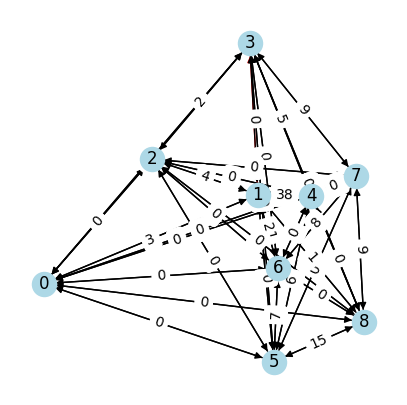

In [3]:
### Алгоритм Левита
import tkinter as tk
from tkinter import filedialog, messagebox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from collections import deque

INF = float('inf')

# Чтение графа из файла
def read_graph_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        graph = []
        for line in lines:
            row = []
            for val in line.strip().split():
                if val.lower() == 'inf':
                    row.append(INF)
                else:
                    row.append(int(val))
            graph.append(row)
        return graph

# Алгоритм Левита
def levit(graph, start):
    V = len(graph)
    dist = [INF] * V
    prev = [None] * V
    m0, m1, m2 = set(), deque(), set()

    dist[start] = 0
    m1.append(start)

    while m1:
        u = m1.popleft()
        m0.discard(u)

        for v in range(V):
            w = graph[u][v]
            if w == INF or u == v:
                continue

            if v not in m0 and v not in m1 and v not in m2:
                dist[v] = dist[u] + w
                prev[v] = u
                m1.append(v)

            elif v in m1 and dist[v] > dist[u] + w:
                dist[v] = dist[u] + w
                prev[v] = u

            elif v in m2 and dist[v] > dist[u] + w:
                dist[v] = dist[u] + w
                prev[v] = u
                m1.appendleft(v)
                m2.remove(v)

        m2.add(u)

    return dist, prev

# Восстановление пути
def reconstruct_path(prev, target):
    path = []
    while target is not None:
        path.append(target)
        target = prev[target]
    return path[::-1]

# Интерфейс на Tkinter
class LevitApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Визуализация алгоритма Левита")

        self.graph = []
        self.dist = []
        self.prev = []

        self.left_frame = tk.Frame(root)
        self.left_frame.pack(side=tk.LEFT, padx=10, pady=10)

        self.load_button = tk.Button(self.left_frame, text="Загрузить граф из файла", command=self.load_graph)
        self.load_button.pack(pady=5)

        self.label_from = tk.Label(self.left_frame, text="Начальная вершина:")
        self.label_from.pack()
        self.entry_from = tk.Entry(self.left_frame)
        self.entry_from.pack()

        self.label_to = tk.Label(self.left_frame, text="Конечная вершина:")
        self.label_to.pack()
        self.entry_to = tk.Entry(self.left_frame)
        self.entry_to.pack()

        self.show_button = tk.Button(self.left_frame, text="Показать кратчайший путь", command=self.show_shortest_path)
        self.show_button.pack(pady=5)

        self.output = tk.Text(self.left_frame, height=6, width=40)
        self.output.pack(pady=5)

        self.right_frame = tk.Frame(root)
        self.right_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.get_tk_widget().pack()

    def load_graph(self):
        file_path = filedialog.askopenfilename()
        if not file_path:
            return
        try:
            self.graph = read_graph_from_file(file_path)
            messagebox.showinfo("Успешно", "Граф успешно загружен!")
            self.draw_graph()
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def draw_graph(self, path=None):
        self.ax.clear()
        G = nx.DiGraph()

        for i in range(len(self.graph)):
            for j in range(len(self.graph[i])):
                if self.graph[i][j] != INF and i != j:
                    G.add_edge(i, j, weight=self.graph[i][j])

        pos = nx.spring_layout(G)
        edge_colors = ['red' if path and (u in path and v in path and path.index(v) == path.index(u) + 1) else 'black' for u, v in G.edges()]

        nx.draw(G, pos, ax=self.ax, with_labels=True, node_color='lightblue', edge_color=edge_colors)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=self.ax)
        self.canvas.draw()

    def show_shortest_path(self):
        try:
            u = int(self.entry_from.get())
            v = int(self.entry_to.get())

            if not (0 <= u < len(self.graph)) or not (0 <= v < len(self.graph)):
                raise ValueError("Неверные номера вершин")

            self.dist, self.prev = levit(self.graph, u)
            path = reconstruct_path(self.prev, v)
            distance = self.dist[v]

            self.output.delete("1.0", tk.END)
            if distance != INF:
                self.output.insert(tk.END, f"Кратчайший путь: {path}\n")
                self.output.insert(tk.END, f"Длина пути: {distance}")
                self.draw_graph(path)
            else:
                self.output.insert(tk.END, "Путь не существует.")
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

# Запуск приложения
if __name__ == "__main__":
    root = tk.Tk()
    app = LevitApp(root)
    root.mainloop()


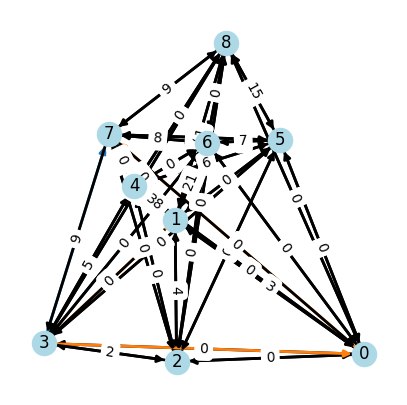

In [20]:
### Алгоритм Йена
import tkinter as tk
from tkinter import filedialog, messagebox
import heapq
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from copy import deepcopy

INF = float('inf')

# --- Чтение графа из файла ---
def read_graph_from_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        graph = []
        for line in lines:
            if line.strip().startswith('#') or not line.strip():
                continue
            row = []
            for val in line.strip().split():
                if val.lower() == 'inf':
                    row.append(INF)
                else:
                    row.append(int(val))
            graph.append(row)
        return graph

# --- Алгоритм Дейкстры ---
def dijkstra_path(graph, start, end):
    V = len(graph)
    dist = [INF] * V
    prev = [None] * V
    dist[start] = 0
    queue = [(0, start)]

    while queue:
        d, u = heapq.heappop(queue)
        if u == end:
            break
        if d > dist[u]:
            continue
        for v, weight in enumerate(graph[u]):
            if weight != INF and dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                prev[v] = u
                heapq.heappush(queue, (dist[v], v))

    path = []
    node = end
    while node is not None:
        path.append(node)
        node = prev[node]
    return path[::-1], dist[end]

# --- Алгоритм Йена ---
def yen_k_shortest_paths(graph, start, end, k):
    A = []
    B = []

    path, cost = dijkstra_path(graph, start, end)
    if not path or cost == INF:
        return []

    A.append((cost, path))

    for i in range(1, k):
        for j in range(len(A[i-1][1]) - 1):
            spur_node = A[i-1][1][j]
            root_path = A[i-1][1][:j+1]

            g_copy = deepcopy(graph)

            for cost_path, p in A:
                if p[:j+1] == root_path and len(p) > j+1:
                    u, v = p[j], p[j+1]
                    g_copy[u][v] = INF

            for node in root_path[:-1]:
                for v in range(len(g_copy)):
                    g_copy[node][v] = INF

            spur_path, spur_cost = dijkstra_path(g_copy, spur_node, end)
            if spur_path and spur_cost != INF:
                total_path = root_path[:-1] + spur_path
                total_cost = sum(graph[total_path[i]][total_path[i+1]] for i in range(len(total_path) - 1))
                if (total_cost, total_path) not in B:
                    B.append((total_cost, total_path))

        if not B:
            break

        B.sort()
        A.append(B.pop(0))

    return A

# --- Интерфейс ---
class YenApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Алгоритм Йена — k кратчайших путей")
        self.graph = []

        self.left_frame = tk.Frame(root)
        self.left_frame.pack(side=tk.LEFT, padx=10, pady=10)

        self.load_button = tk.Button(self.left_frame, text="Загрузить граф", command=self.load_graph)
        self.load_button.pack(pady=5)

        tk.Label(self.left_frame, text="Начальная вершина:").pack()
        self.entry_from = tk.Entry(self.left_frame)
        self.entry_from.pack()

        tk.Label(self.left_frame, text="Конечная вершина:").pack()
        self.entry_to = tk.Entry(self.left_frame)
        self.entry_to.pack()

        tk.Label(self.left_frame, text="Количество путей (k):").pack()
        self.entry_k = tk.Entry(self.left_frame)
        self.entry_k.pack()

        self.find_button = tk.Button(self.left_frame, text="Показать пути", command=self.find_paths)
        self.find_button.pack(pady=5)

        self.output = tk.Text(self.left_frame, height=15, width=45)
        self.output.pack(pady=5)

        self.right_frame = tk.Frame(root)
        self.right_frame.pack(side=tk.RIGHT, padx=10, pady=10)

        self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas.get_tk_widget().pack()

    def load_graph(self):
        file_path = filedialog.askopenfilename()
        if not file_path:
            return
        try:
            self.graph = read_graph_from_file(file_path)
            messagebox.showinfo("Успешно", "Граф загружен!")
            self.draw_graph()
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

    def draw_graph(self, paths=None):
        self.ax.clear()
        G = nx.DiGraph()
        for i in range(len(self.graph)):
            for j in range(len(self.graph[i])):
                if self.graph[i][j] != INF and i != j:
                    G.add_edge(i, j, weight=self.graph[i][j])

        pos = nx.spring_layout(G, seed=42)

        edge_colors = ['black'] * len(G.edges)
        if paths:
            edge_map = {}
            for idx, (_, path) in enumerate(paths):
                for i in range(len(path) - 1):
                    edge_map[(path[i], path[i + 1])] = f"C{idx % 10}"  # 10 разных цветов

            edge_colors = [edge_map.get((u, v), 'black') for u, v in G.edges]

        nx.draw(G, pos, ax=self.ax, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=2)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=self.ax)
        self.canvas.draw()

    def find_paths(self):
        try:
            if not self.graph:
                raise ValueError("Сначала загрузите граф.")

            u = int(self.entry_from.get())
            v = int(self.entry_to.get())
            k = int(self.entry_k.get())

            if not (0 <= u < len(self.graph)) or not (0 <= v < len(self.graph)):
                raise ValueError("Некорректные номера вершин.")

            paths = yen_k_shortest_paths(self.graph, u, v, k)
            self.output.delete("1.0", tk.END)

            if not paths:
                self.output.insert(tk.END, "Пути не найдены.")
                self.draw_graph()
                return

            for i, (cost, path) in enumerate(paths):
                self.output.insert(tk.END, f"{i + 1}) Путь: {path}, Стоимость: {cost}\n")

            self.draw_graph(paths)
        except Exception as e:
            messagebox.showerror("Ошибка", str(e))

# --- Запуск интерфейса ---
if __name__ == "__main__":
    root = tk.Tk()
    app = YenApp(root)
    root.mainloop()
